In [1]:
import matplotlib.pyplot as plt
import sys

from parser.parser import process_dxf, convert_units
from calcs.calc_cable_size import cable_sizing
from calcs.calc_tolerables import surface_correction, Etouch, Estep
from calcs.calc_gpr import gpr

from calcs.class_grid import GroundingGrid
from calcs.class_geom_etry import Geom_etry 

G_grid=None
Geo_Grid=None


In [2]:
def plot_grid_with_lines_and_rods(filepath, fileunits, polygon=None, complete=True, title="Grounding Grid"):
    """
    Plot the grounding grid polygon along with the lines_list and rods_list.
    
    Args:
        polygon: The Shapely polygon object representing the grounding grid.
        lines_list: A list of line segments (each line is a list of two points).
        rods_list: A list of rod positions (each rod is a tuple of x, y coordinates).
        title: The title of the plot.
    
    """
    # Parse the DXF file to get the lines and rods
    lines_list_raw, rods_list_raw = process_dxf(filepath)

    # Scale the lines and rods
    lines_list, rods_list =convert_units(lines_list_raw, rods_list_raw, fileunits)

     # Create a figure and axes
    fig, ax = plt.subplots(figsize=(8, 8))

    if polygon is not None:
        # Plot the polygon
        x, y = polygon.exterior.xy
        ax.plot(x, y, 'b-', label="Polygon Boundary")  # Polygon boundary in blue


    if complete:
         # Plot the lines_list
        for line in lines_list:
            x, y = zip(*line)
            ax.plot(x, y, 'b-', label="Lines" if 'Lines' not in ax.get_legend_handles_labels()[1] else "")  # Lines in blue

        # Plot the rods_list
        for rod in rods_list:
            x, y = rod
            ax.plot(x, y, 'ro', label="Rods" if 'Rods' not in ax.get_legend_handles_labels()[1] else "")  # Rods as red dots

    # Add labels and legend
    ax.set_title(title)
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.grid(True)
    ax.legend()
    ax.set_aspect('equal', adjustable='datalim', anchor='C')

    # Set x-axis limits based on the data
    all_x = [point[0] for line in lines_list for point in line] + [rod[0] for rod in rods_list]
    x_min, x_max = min(all_x), max(all_x)
    ax.set_xlim(x_min - 10, x_max + 10)  # Add some padding to the x-axis limits

    # Return the figure
    return fig

In [3]:
# Defining Main calculation function

def ground_grid(filepath, fileunits,conductor_type, short_circuit_conductor,short_circuit, fault_duration, person_weight, cable_depth,
                depth_crushed_rock, ro, ros, ambient_temperature, split_factor, rod_length, rod_diameter, case, nrods=None):
    
    # Parse the DXF file to get the lines and rods
    lines_list_raw, rods_list_raw = process_dxf(filepath)

    # Scale the lines and rods
    lines_list, rods_list =convert_units(lines_list_raw, rods_list_raw, fileunits)

    # Calculate the effective short-circuit current
    effective_short_circuit = short_circuit * split_factor  # Adjusting for the split factor

    # Instantiate the Geom_etry class
    Geo_Grid = Geom_etry(lines_list,rods_list)
    
    # Calculate the selected cable and cable diameter
    cable_area,selected_cable, cable_diameter=cable_sizing(conductor_type, short_circuit_conductor, fault_duration, 
                                                ambient_temperature)
    


    # Printing the values for debugging
    print(f"Filepath: {filepath}")
    print(f"Lines List Raw: {lines_list_raw}")
    print(f"Rods List Raw: {rods_list_raw}")
    print(f"Lines List: {lines_list}")
    print(f"Rods List: {rods_list}")
    # print(f"conductor_type: {conductor_type}, short_circuit: {short_circuit}, fault_duration: {fault_duration:.2f} seconds")
    print(f"Cable Area: {cable_area},Selected Cable: {selected_cable}, Cable Diameter: {cable_diameter:.2f} mm")

    # Values to print and debug
    poly=Geo_Grid.polyg_on

    # Plot to debug the geometry
    plot_grid_with_lines_and_rods(filepath, fileunits,poly, title="Grounding Grid with Lines and Rods")
    # plot_grid_with_lines_and_rods(filepath, fileunits,poly, complete=False, title="Polygon Only")

    # Values to print
    print(f"Largest Horizontal Line: {Geo_Grid.largest_horizontal}")
    print(f"Largest Vertical Line: {Geo_Grid.largest_vertical}")
    print("shape", Geo_Grid.shape)
    print("side1", Geo_Grid.side1)
    print("side2", Geo_Grid.side2)
    print("side3", Geo_Grid.side3)
    print("side4", Geo_Grid.side4)
    print("total_area", Geo_Grid.area)
    print("perimeter", Geo_Grid.perimeter)
    print("Lx", Geo_Grid.max_length_x)
    print("Ly", Geo_Grid.max_length_y)
    print("D", Geo_Grid.max_separation)
    print("Dm", Geo_Grid.max_dist)
    print("cable_diameter", cable_diameter)
    print("nrods",len(rods_list))
    print("Lr", rod_length*len(rods_list))
    print("Lc", Geo_Grid.line_lengths)
    print("location_rods", Geo_Grid.location_rods)
    print(f"Effective Short-Circuit Current: {effective_short_circuit:.2f} kA")

       

    # # TODO: Hide this, applicable only for benchmarking purposes
    # cable_diameter=10

    # Instantiate the GroundingGrid class
    G_grid = GroundingGrid(ro, cable_depth, cable_diameter/1000, len(rods_list), rod_length, rod_diameter,
                           case=case, location_rods=Geo_Grid.location_rods, D=Geo_Grid.max_separation, shape=Geo_Grid.shape,
                            side1=Geo_Grid.side1, side2=Geo_Grid.side2, side3=Geo_Grid.side3, side4=Geo_Grid.side4,
                            A=Geo_Grid.area, Lc=Geo_Grid.line_lengths,Lp=Geo_Grid.perimeter, Dm=Geo_Grid.max_dist,
                            Lx=Geo_Grid.max_length_x, Ly=Geo_Grid.max_length_y)

    # Calculate the grounding grid resistance
    Rg=float(G_grid.Rpt)

    # Calculate the Ground Potential Rise (GPR)
    gpr_value = float(gpr(Rg, effective_short_circuit*1000))

    # Calculate the surface correction factor
    Cs = surface_correction(ro, ros, depth_crushed_rock)

    # Calculate tolerable values
    tolerable_touch = float(Etouch(ros, Cs, fault_duration, weight=person_weight))
    tolerable_step = float(Estep(ros, Cs, fault_duration, weight=person_weight))

    # Compare the calculated GPR with the tolerable values
    if gpr_value > tolerable_touch and gpr_value > tolerable_step:
        pass
    else:
        print("GPR is below the touch and step tolerable limits.")
        return {
        "selected_cable": {selected_cable, "--"},
        "cable_diameter": {round(cable_diameter, 2), "mm"},
        "effective_short_circuit": {round(effective_short_circuit * 1000, 2), "A"},
        "Rg": {round(Rg, 2), "Ohms"},
        "gpr": {round(gpr_value, 2), "V"},
        "tolerable_touch": {round(tolerable_touch, 2), "V"},
        "tolerable_step": {round(tolerable_step, 2), "V"},
        }
        sys.exit(0)


    # Calculate the touch and step potentials
    touch_potential = float(G_grid.Em(effective_short_circuit*1000))  
    step_potential = float(G_grid.Es(effective_short_circuit*1000))

    # Printing the results for benchmarking
    print(f"Grounding Grid Resistance (Rg): {Rg:.2f} Ohms")
    print("Rpt.kh", G_grid.kh)
    print("Rpt.km",G_grid.km)
    print("Rpt.ki",G_grid.ki)
    print("Rpt.Kii",G_grid.kii)
    print("Rpt.Lm",G_grid.Lm)
    print("Rpt.Lr",G_grid.LR)
    print("Rpt.Lc",G_grid.Lc)
    print("Rpt.Lp",G_grid.Lp)
    print("Rpt.Lx",G_grid.Lx)
    print("Rpt.Ly",G_grid.Ly)
    print("Rpt.na",G_grid.na)
    print("Rpt.nb",G_grid.nb)
    print("Rpt.nc",G_grid.nc)
    print("Rpt.nd",G_grid.nd)
    print("Rpt.ncalc_",G_grid.n)
    print(f"Touch Potential: {touch_potential:.2f} V")
    print(f"Step Potential: {step_potential:.2f} V")
    print(f"Tolerable Touch Potential: {tolerable_touch:.2f} V")
    print(f"Tolerable Step Potential: {tolerable_step:.2f} V")
    print(f"Ground Potential Rise (GPR): {gpr_value:.2f} V")

    if touch_potential > tolerable_touch:
        print("Warning: Touch potential exceeds tolerable limits!")
    else:
        print("Touch potential is within tolerable limits.")

    if step_potential > tolerable_step:
        print("Warning: Step potential exceeds tolerable limits!")
    else:
        print("Step potential is within tolerable limits.")
    

    results = {
        "Selected Cable": f"{selected_cable}",
        "Cable Diameter": f"{round(cable_diameter, 2)} mm",
        "Conductor Short Circuit": f"{round(short_circuit_conductor, 2)} kA",
        "Grounding Resistance": f"{round(Rg, 2)} Ohms",
        "GPR": f"{round(gpr_value, 2)} V",
        "Tolerable Touch Voltage": f"{round(tolerable_touch, 2)} V",
        "Tolerable Step Voltage": f"{round(tolerable_step, 2)} V",
        "Touch Voltage": f"{round(touch_potential, 2)} V",
        "Step Potential": f"{round(step_potential, 2)} V",
    }

    # Formatting the results for better readability
    formatted_results = "Results:\n" + "\n".join([f"{key}: {value}" for key, value in results.items()])
    print(formatted_results)

    return results

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Filepath: Fig_B2__mm.dxf
Lines List Raw: [[(0.0, 0.0), (70000.0, 0.0)], [(70000.0, 0.0), (70000.0, 70000.0)], [(70000.0, 70000.0), (0.0, 70000.0)], [(0.0, 70000.0), (0.0, 0.0)], [(0.0, 7000.0), (70000.0, 7000.0)], [(63000.0, 0.0), (63000.0, 70000.0)], [(70000.0, 63000.0), (0.0, 63000.0)], [(7000.0, 70000.0), (7000.0, 0.0)], [(70000.0, 56000.0), (0.0, 56000.0)], [(70000.0, 49000.0), (0.0, 49000.0)], [(70000.0, 42000.0), (0.0, 42000.0)], [(70000.0, 35000.0), (0.0, 35000.0)], [(70000.0, 28000.0), (0.0, 28000.0)], [(70000.0, 21000.0), (0.0, 21000.0)], [(70000.0, 14000.0), (0.0, 14000.0)], [(14000.0, 70000.0), (14000.0, 0.0)], [(21000.0, 70000.0), (21000.0, 0.0)], [(28000.0, 70000.0), (28000.0, 0.0)], [(35000.0, 70000.0), (35000.0, 0.0)], [(42000.0, 70000.0), (42000.0, 0.0)], [(49000.0, 70000.0), (49000.0, 0.0)], [(56000.0, 70000.0), (56000.0, 0.0)]]
Rods List Raw: [(0.0, 70000.0), (14000.0, 70000.0), (28000.0, 70000.0), (42000.0, 70000.0), (56000.0, 70000.0), (70000.0, 70000.0), (0.0, 0.0)

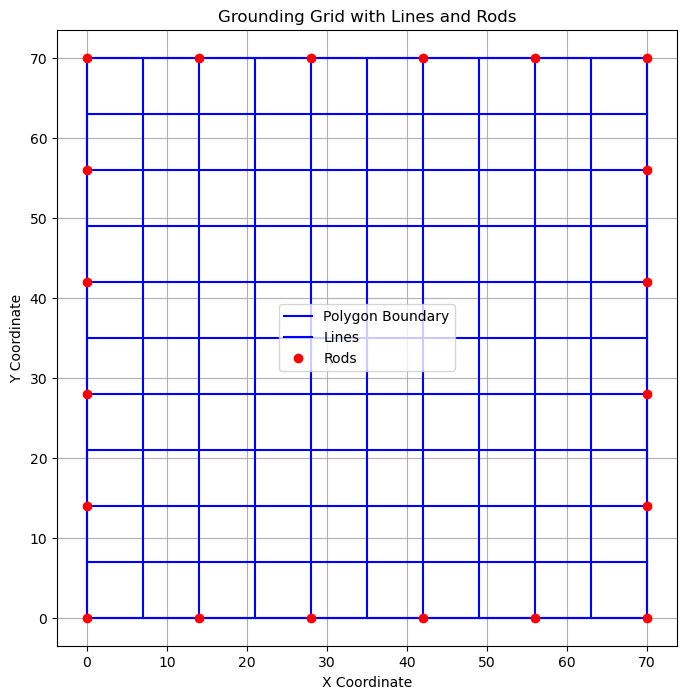

In [4]:
if __name__ == '__main__':
    
    # Example IEEE B1

    # inputs
    filepath = "Fig_B2__mm.dxf"
    fileunits="mm"
    conductor_type = "Copper, anealed soft-drawn"
    short_circuit_conductor = 30.814 # kA
    short_circuit = 3.18  # kA
    fault_duration = 0.5  # seconds
    person_weight = 70  # kg
    cable_depth = 0.5  # meters
    depth_crushed_rock = 0.102  # meters
    ro = 400  # Ohm-m
    ros = 2500  # Ohm-m
    ambient_temperature = 40  # Celsius
    split_factor = 0.6  # Unitless
    rod_length = 7.5 # meters
    rod_diameter = 0.02  # meters
    case="Sverak"

    

    results = ground_grid(filepath, fileunits, conductor_type, short_circuit_conductor,short_circuit, fault_duration, person_weight, cable_depth,
                          depth_crushed_rock, ro, ros, ambient_temperature, split_factor, rod_length, rod_diameter, case)

    print("Results:", results)

    

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Filepath: Fig_B2__mm.dxf
Lines List Raw: [[(0.0, 0.0), (70000.0, 0.0)], [(70000.0, 0.0), (70000.0, 70000.0)], [(70000.0, 70000.0), (0.0, 70000.0)], [(0.0, 70000.0), (0.0, 0.0)], [(0.0, 7000.0), (70000.0, 7000.0)], [(63000.0, 0.0), (63000.0, 70000.0)], [(70000.0, 63000.0), (0.0, 63000.0)], [(7000.0, 70000.0), (7000.0, 0.0)], [(70000.0, 56000.0), (0.0, 56000.0)], [(70000.0, 49000.0), (0.0, 49000.0)], [(70000.0, 42000.0), (0.0, 42000.0)], [(70000.0, 35000.0), (0.0, 35000.0)], [(70000.0, 28000.0), (0.0, 28000.0)], [(70000.0, 21000.0), (0.0, 21000.0)], [(70000.0, 14000.0), (0.0, 14000.0)], [(14000.0, 70000.0), (14000.0, 0.0)], [(21000.0, 70000.0), (21000.0, 0.0)], [(28000.0, 70000.0), (28000.0, 0.0)], [(35000.0, 70000.0), (35000.0, 0.0)], [(42000.0, 70000.0), (42000.0, 0.0)], [(49000.0, 70000.0), (49000.0, 0.0)], [(56000.0, 70000.0), (56000.0, 0.0)]]
Rods List Raw: [(0.0, 70000.0), (14000.0, 70000.0), (28000.0, 70000.0), (42000.0, 70000.0), (56000.0, 70000.0), (70000.0, 70000.0), (0.0, 0.0)

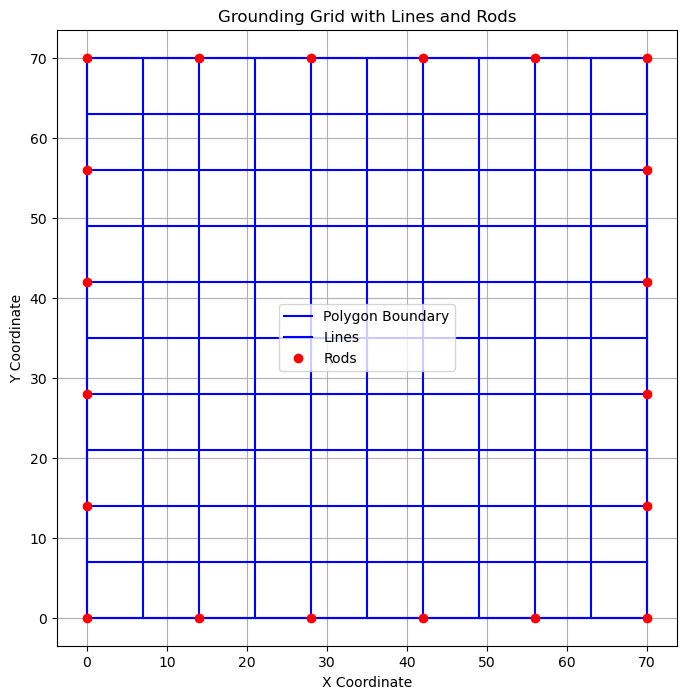

In [5]:
# Example IEEE B2

# inputs
filepath = "Fig_B2__mm.dxf"
fileunits="mm"
conductor_type = "Copper, anealed soft-drawn"
short_circuit_conductor = 6.814 # kA
short_circuit = 3.18  # kA
fault_duration = 0.5  # seconds
person_weight = 70  # kg
cable_depth = 0.5  # meters
depth_crushed_rock = 0.102  # meters
ro = 400  # Ohm-m
ros = 2500  # Ohm-m
ambient_temperature = 40  # Celsius
split_factor = 0.6  # Unitless
rod_length = 7.5 # meters
rod_diameter = 0.02  # meters
case="Sverak"



results = ground_grid(filepath, fileunits, conductor_type, short_circuit_conductor,short_circuit, fault_duration, person_weight, cable_depth,
                        depth_crushed_rock, ro, ros, ambient_temperature, split_factor, rod_length, rod_diameter, case)

print("Results:", results)


Filepath: Fig_B3__m.dxf
Lines List Raw: [[(84.00000000000001, 0.0), (84.00000000000001, 63.0)], [(77.00000000000001, 4e-16), (77.00000000000001, 63.0)], [(70.00000000000001, 9e-16), (70.00000000000001, 63.0)], [(63.00000000000001, 1.3e-15), (63.00000000000001, 63.0)], [(56.00000000000001, 1.7e-15), (56.00000000000001, 63.0)], [(49.00000000000002, 2.1e-15), (49.00000000000002, 63.0)], [(42.00000000000001, 2.6e-15), (42.00000000000001, 63.0)], [(35.00000000000002, 3e-15), (35.00000000000002, 63.0)], [(28.00000000000002, 3.4e-15), (28.00000000000002, 63.0)], [(84.00000000000001, 0.0), (1.42e-14, 5.1e-15)], [(84.00000000000001, 7.0), (1.42e-14, 7.000000000000005)], [(84.00000000000001, 14.0), (1.42e-14, 14.0)], [(84.00000000000001, 21.0), (1.42e-14, 21.0)], [(84.00000000000001, 28.0), (1.42e-14, 28.00000000000001)], [(84.00000000000001, 35.0), (1.42e-14, 35.00000000000001)], [(84.00000000000001, 42.0), (1.42e-14, 42.00000000000001)], [(84.00000000000001, 49.0), (1.42e-14, 49.00000000000001

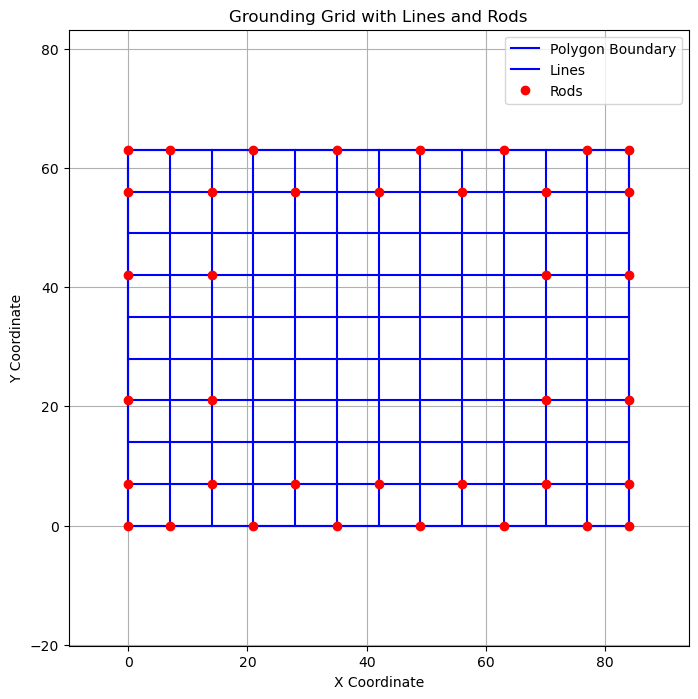

In [6]:
# Example IEEE B3

# inputs
filepath = "Fig_B3__m.dxf"
fileunits="m"
conductor_type = "Copper, anealed soft-drawn"
short_circuit_conductor = 6.814 # kA
short_circuit = 3.18  # kA
fault_duration = 0.5  # seconds
person_weight = 70  # kg
cable_depth = 0.5  # meters
depth_crushed_rock = 0.102  # meters
ro = 400  # Ohm-m
ros = 2500  # Ohm-m
ambient_temperature = 40  # Celsius
split_factor = 0.6  # Unitless
rod_length = 10 # meters
rod_diameter = 0.02  # meters
case="Sverak"



results = ground_grid(filepath, fileunits, conductor_type, short_circuit_conductor,short_circuit, fault_duration, person_weight, cable_depth,
                        depth_crushed_rock, ro, ros, ambient_temperature, split_factor, rod_length, rod_diameter, case)

print("Results:", results)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Filepath: Fig_B4__mm.dxf
Lines List Raw: [[(0.0, 105000.0), (0.0, 0.0)], [(0.0, 0.0), (70000.0, 0.0)], [(70000.0, 0.0), (70000.0, 35000.0)], [(0.0, 7000.0), (70000.0, 7000.0)], [(63000.0, 0.0), (63000.0, 35000.0)], [(35000.0, 63000.0), (0.0, 63000.0)], [(7000.0, 105000.0), (7000.0, 0.0)], [(35000.0, 56000.0), (0.0, 56000.0)], [(35000.0, 49000.0), (0.0, 49000.0)], [(35000.0, 42000.0), (0.0, 42000.0)], [(70000.0, 35000.0), (0.0, 35000.0)], [(70000.0, 28000.0), (0.0, 28000.0)], [(70000.0, 21000.0), (0.0, 21000.0)], [(70000.0, 14000.0), (0.0, 14000.0)], [(14000.0, 105000.0), (14000.0, 0.0)], [(21000.0, 105000.0), (21000.0, 0.0)], [(28000.0, 105000.0), (28000.0, 0.0)], [(35000.0, 105000.0), (35000.0, 0.0)], [(42000.0, 35000.0), (42000.0, 0.0)], [(49000.0, 35000.0), (49000.0, 0.0)], [(56000.0, 35000.0), (56000.0, 0.0)], [(35000.0, 91000.0), (0.0, 91000.0)], [(35000.0, 84000.0), (0.0, 84000.0)], [(35000.0, 77000.0), (0.0, 77000.0)], [(35000.0, 70000.0), (0.0, 70000.0)], [(35000.0, 105000.0), 

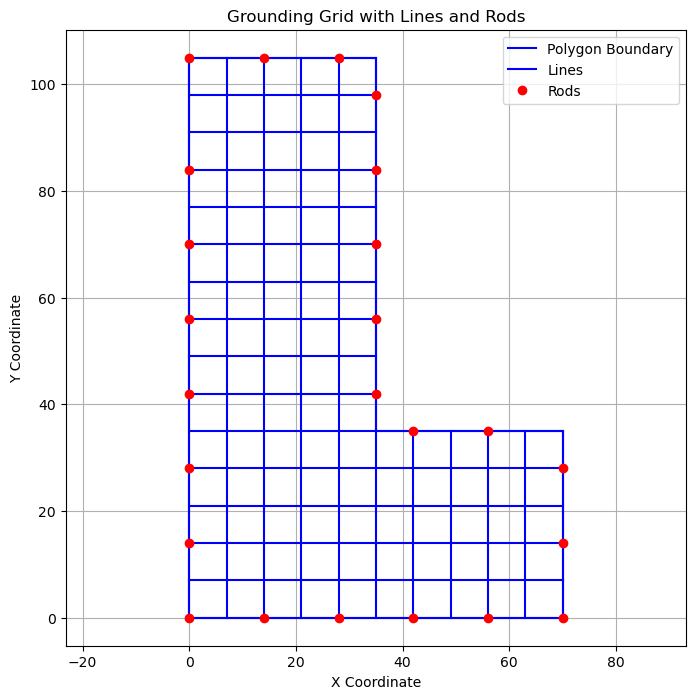

In [7]:
# Example IEEE B4

# inputs
filepath = "Fig_B4__mm.dxf"
fileunits="mm"
conductor_type = "Copper, anealed soft-drawn"
short_circuit_conductor = 6.814 # kA
short_circuit = 3.18  # kA
fault_duration = 0.5  # seconds
person_weight = 70  # kg
cable_depth = 0.5  # meters
depth_crushed_rock = 0.102  # meters
ro = 400  # Ohm-m
ros = 2500  # Ohm-m
ambient_temperature = 40  # Celsius
split_factor = 0.6  # Unitless
rod_length = 7.5 # meters
rod_diameter = 0.02  # meters
case="Sverak"



results = ground_grid(filepath, fileunits, conductor_type, short_circuit_conductor,short_circuit, fault_duration, person_weight, cable_depth,
                        depth_crushed_rock, ro, ros, ambient_temperature, split_factor, rod_length, rod_diameter, case)

print("Results:", results)